In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel2, jn

In [78]:
def circle_data(a, N):
    """
    Calculate coordinates, lengths, angles, and normals for points on a circle.

    Args:
        a (float): Radius of the circle.
        N (int): Number of points to generate.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y), lengths, angles,
                       and normals for each point.
    """
    # xn yn xn+1 yn+1 ln phi_n nx ny
    data = np.zeros((N, 2))
    # Calculate coordinates xn, yn
    for i in range(N):
        xn = a * np.cos((2 * np.pi / N) * (i))
        yn = a * np.sin((2 * np.pi / N) * (i))
        data[i, 0] = xn
        data[i, 1] = yn
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    # Calculate ln, phi_n, nx, ny
    ln = np.sqrt((data[:, 2] - data[:, 0])**2 + (data[:, 3] - data[:, 1])**2)
    phi_n = np.arctan2(data[:, 3] - data[:, 1], data[:, 2] - data[:, 0])
    nx = (data[:, 3] - data[:, 1]) / ln
    ny = -(data[:, 2] - data[:, 0]) / ln
    # Concatenate calculated values to data array
    data = np.column_stack((data, ln, phi_n, nx, ny))    
    return data

def circle_data_aux(a, N):
    """
    Calculate coordinates, lengths, angles, and normals for points on a circle.

    Args:
        a (float): Radius of the circle.
        N (int): Number of points to generate.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y), lengths, angles,
                       and normals for each point.
    """
    # xn yn xn+1 yn+1 ln phi_n nx ny
    data = np.zeros((N, 2))
    # Calculate coordinates xn, yn
    for i in range(N):
        xn = a * np.cos((2 * np.pi / N) * (i))
        yn = a * np.sin((2 * np.pi / N) * (i))
        data[i, 0] = xn
        data[i, 1] = yn
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    # Calculate ln, phi_n, nx, ny
    ln = np.sqrt((data[:, 2] - data[:, 0])**2 + (data[:, 3] - data[:, 1])**2)
    phi_n = np.arctan2(data[:, 3] - data[:, 1], data[:, 2] - data[:, 0])
    nx = (data[:, 3] - data[:, 1]) / ln
    ny = -(data[:, 2] - data[:, 0]) / ln
    # Concatenate calculated values to data array
    data = np.column_stack((data, ln, phi_n, nx, ny))    
    return data


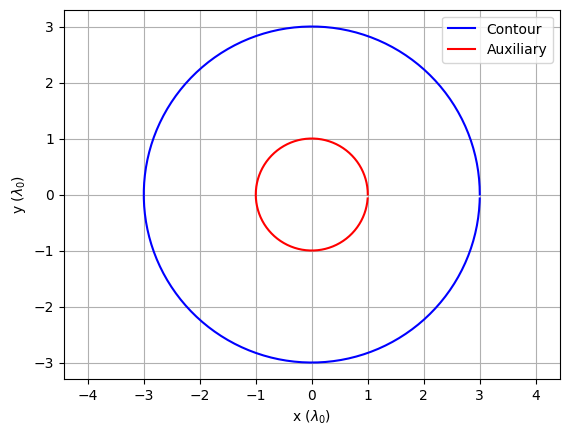

In [79]:
# Plot the auxiliary circle and the circle with different radii a
a_contour = 3
a_aux = 1
M = 15*int(2*np.pi*a_contour)
N = 15*int(2*np.pi*a_aux)

data_contour = circle_data(a_contour, M)
data_aux = circle_data_aux(a_aux, N)

fig, ax = plt.subplots()
ax.plot(data_contour[:, 0], data_contour[:, 1], 'b')
ax.plot(data_aux[:, 0], data_aux[:, 1], 'r')
ax.axis('equal')
plt.xlabel(r'x $(\lambda_{0})$')
plt.ylabel(r'y $(\lambda_{0})$')
plt.legend(['Contour', 'Auxiliary'])    
plt.grid()
plt.show()


In [80]:
def calculate_current_distribution_aux_sources(a_contour, a_aux, data_contour, data_aux, phi_i):
    k = 2 * np.pi  # Wavenumber
    phi_i = np.deg2rad(phi_i)  # Angle of incidence in radians
    M = len(data_contour)  # Number of segments
    N = len(data_aux)  # Number of auxiliary sources
    Z = np.zeros((M, N), dtype=complex)
    V = np.zeros((M, 1), dtype=complex)
    
    for l in range(N):
        xm = data_aux[l, 0]
        ym = data_aux[l, 1]
        lm = data_aux[l, 4]
        phi_m = data_aux[l, 5]
        xm_ = xm + 0.5 * lm * np.cos(phi_m)
        ym_ = ym + 0.5 * lm * np.sin(phi_m)
        for m in range(M):
            xl = data_contour[m, 0]
            yl = data_contour[m, 1]
            ll = data_contour[m, 4]
            phi_l = data_contour[m, 5]
            xl_ = xl + 0.5 * ll * np.cos(phi_l)
            yl_ = yl + 0.5 * ll * np.sin(phi_l)
            rml = np.sqrt((xm_ - xl_)**2 + (ym_ - yl_)**2)
            Z[m,l] += hankel2(0, k * rml)

    for i in range(M):
        xm = data_contour[i, 0]
        ym = data_contour[i, 1]
        lm = data_contour[i, 4]
        phi_m = data_contour[i, 5]
        xm_ = xm + 0.5 * lm * np.cos(phi_m)
        ym_ = ym + 0.5 * lm * np.sin(phi_m)
        V[i] = np.exp(1j * k * (xm_ * np.cos(phi_i) + ym_ * np.sin(phi_i)))
    # Solve the regularized least squares problem
    I, residuals, _, _ = np.linalg.lstsq(Z, -V, rcond=0.01)
    return I

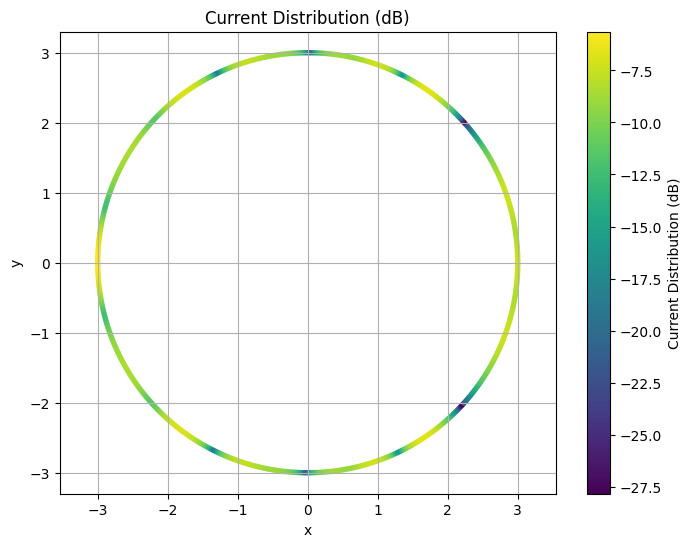

In [81]:
# Plot the current distribution on the contour
a_contour = 3
a_aux = 2.9
M = 50*int(2*np.pi*a_contour)
N = 30*int(2*np.pi*a_aux)

data_contour = circle_data(a_contour, M)
data_aux = circle_data_aux(a_aux, N)
phi_i = 0   # Angle of incidence in degrees
I = calculate_current_distribution_aux_sources(a_contour, a_aux, data_contour, data_aux, phi_i)

def calculate_db_scat(scat):
    return 10 * np.log10(np.abs(scat))

def plot_current_distribution_db(I, a_contour, N):
    I_db = calculate_db_scat(I)

    data = circle_data(a_contour, N)
    xn = data[:, 0]
    yn = data[:, 1]

    # Plot current distribution in dB
    plt.figure(figsize=(8, 6))
    plt.scatter(xn, yn, c=I_db, cmap='viridis', marker='.', label='Current Distribution (dB)')
    plt.colorbar(label='Current Distribution (dB)')
    plt.title('Current Distribution (dB)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

plot_current_distribution_db(I, a_contour, N)

In [82]:
def scattered_field(data, I, xn_grid, yn_grid):
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    e_scat = np.zeros((N, N), dtype=complex)  # Initialize scattered field vector
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            lm = data[j, 4]  # Length of the segment
            phi_m = data[j, 5]  # Angle of the segment
            # Calculate midpoint coordinates
            xm_ = xm + 0.5 * lm * np.cos(phi_m)
            ym_ = ym + 0.5 * lm * np.sin(phi_m)

            r = np.sqrt((xn - xm_)**2 + (yn - ym_)**2)
            e_scat[i] += hankel2(0, k * r) * I[j,0]
    return e_scat

def scattered_field_obs(data, I, xn_grid, yn_grid):
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    e_scat = np.zeros((N, 1), dtype=complex)  # Initialize scattered field vector
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            lm = data[j, 4]  # Length of the segment
            phi_m = data[j, 5]  # Angle of the segment
            # Calculate midpoint coordinates
            xm_ = xm + 0.5 * lm * np.cos(phi_m)
            ym_ = ym + 0.5 * lm * np.sin(phi_m)

            r = np.sqrt((xn - xm_)**2 + (yn - ym_)**2)
            e_scat[i][0] += hankel2(0, k * r) * I[j,0]
    return e_scat

def incident_field(xn_grid, yn_grid, phi_inc):
    k = 2 * np.pi 
    N = len(xn_grid)

    phi_inc = np.deg2rad(phi_inc)  # Angle of incidence in radians

    e_inc = np.zeros((N, N), dtype=complex)  # Initialize incident field vector
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        e_inc[i] = np.exp(1j * k * (xn * np.cos(phi_inc) + yn * np.sin(phi_inc)))
    return e_inc    


In [83]:
grid_size = N  # Size of the grid
x_min, x_max = -15, 15  # X-coordinate range
y_min, y_max = -15, 15  # Y-coordinate range


x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

# Calculate distance of each grid point from the center of the circle
distance_to_center = np.sqrt((x_grid)**2 + (y_grid)**2)

# Remove points within the circular region
mask = distance_to_center < a_contour
x_grid[mask] = np.nan
y_grid[mask] = np.nan

e_scat_aux = scattered_field(data_aux, I, x_grid, y_grid)
e_inc = incident_field(x_grid, y_grid, phi_i)
e_total = e_inc + e_scat_aux



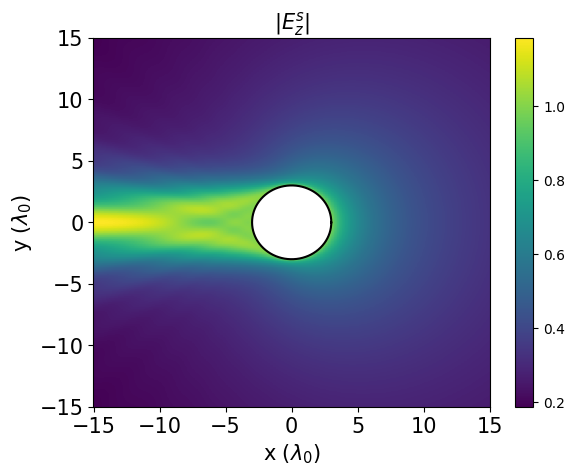

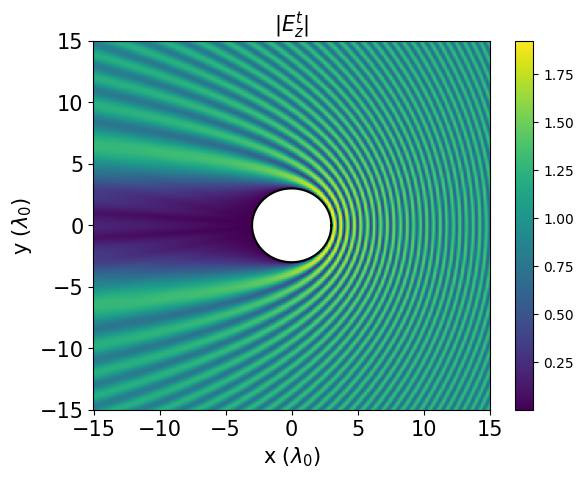

In [84]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_scat_aux), shading='auto')
plt.title(r'|$E^{s}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_total), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [85]:
a_obs = 10
a_aux = 2
M = 20*int(2*np.pi*a_aux)
J = 1
data_obs = circle_data(a_obs, N)
data_aux = circle_data_aux(a_aux, M)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]
l_obs = data_obs[:, 4]
phi_obs = data_obs[:, 5]
x_obs_ = x_obs + 0.5 * l_obs * np.cos(phi_obs)
y_obs_ = y_obs + 0.5 * l_obs * np.sin(phi_obs)

phi_i = np.linspace(0, 360, J)

scattered_fields = np.zeros((M, J), dtype=complex)

for j in range(J):
    I = calculate_current_distribution_aux_sources(a_contour, a_aux, data_contour, data_aux, phi_i[j])
    e_scat = scattered_field_obs(data_aux, I, x_obs_, y_obs_)
    scattered_fields[:, j] = e_scat[:, 0]

print("Number of auxiliary sources: ", M)
print("Number of observation points: ", N)


Number of auxiliary sources:  240
Number of observation points:  540


In [86]:
def cv_inverse_scattering(data_obs, data_aux, J, scattered_field, phi_i):
    M = len(data_obs)  # Number of observable points
    N = len(data_aux)  # Number of auxiliary sources
    k = 2 * np.pi  # Wavenumber
    phi_i = np.deg2rad(phi_i)  # Angle of incidence in radians
    Z = np.zeros((N, M), dtype=complex)
    cv = np.zeros((M, J), dtype=complex)

    for j in range(J):
        for m in range(N):
            xm = data_aux[m, 0]
            ym = data_aux[m, 1]
            lm = data_aux[m, 4]
            phi_m = data_aux[m, 5]
            xm_ = xm + 0.5 * lm * np.cos(phi_m)
            ym_ = ym + 0.5 * lm * np.sin(phi_m)
            for l in range(M):
                xl = data_obs[l, 0]
                yl = data_obs[l, 1]
                ll = data_obs[l, 4]
                phi_l = data_obs[l, 5]
                xl_ = xl + 0.5 * ll * np.cos(phi_l)
                yl_ = yl + 0.5 * ll * np.sin(phi_l)
                rml = np.sqrt((xm_ - xl_)**2 + (ym_ - yl_)**2)
                Z[m,l] += hankel2(0, k * rml)
        # Solve the regularized least squares problem
        cv[:,j], residuals, _, _ = np.linalg.lstsq(Z, scattered_field[:,j], rcond=0.01)

    return cv

In [87]:
cv = cv_inverse_scattering(data_obs, data_aux, J, scattered_fields, phi_i)

In [88]:
def inverse_scattered_field(data, I, xn_grid, yn_grid):
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    e_inv_scat = np.zeros((N, N), dtype=complex)  # Initialize scattered field vector
    for l in range(I.shape[1]):
        for i in range(N):
            xn = xn_grid[i]
            yn = yn_grid[i]
            for j in range(N):
                xm = data[j, 0]  # x-coordinate of the point on the contour
                ym = data[j, 1]  # y-coordinate of the point on the contour
                lm = data[j, 4]  # Length of the segment
                phi_m = data[j, 5]  # Angle of the segment
                # Calculate midpoint coordinates
                xm_ = xm + 0.5 * lm * np.cos(phi_m)
                ym_ = ym + 0.5 * lm * np.sin(phi_m)

                r = np.sqrt((xn - xm_)**2 + (yn - ym_)**2)
                e_inv_scat[i] += hankel2(0, k * r) * I[j,l]
    return e_inv_scat

In [89]:
grid_size = M  # Size of the grid
x_min, x_max = -5, 5  # X-coordinate range
y_min, y_max = -5, 5  # Y-coordinate range


x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)

e_inv_inc = np.zeros((M, M), dtype=complex)
for j in range(J):
    e_inv_inc += incident_field(x_grid, y_grid, phi_i[j])
    
e_total = e_inv_inc + e_inv_scat

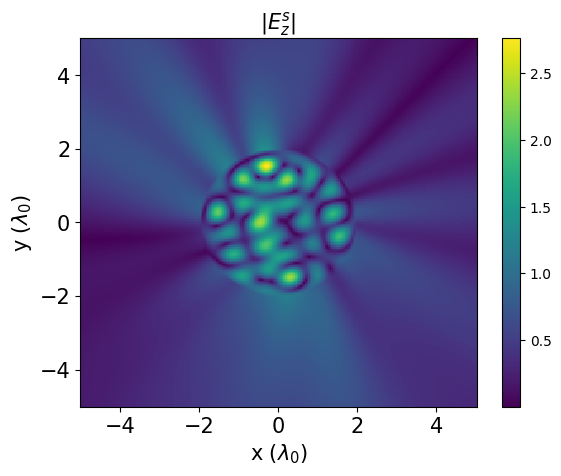

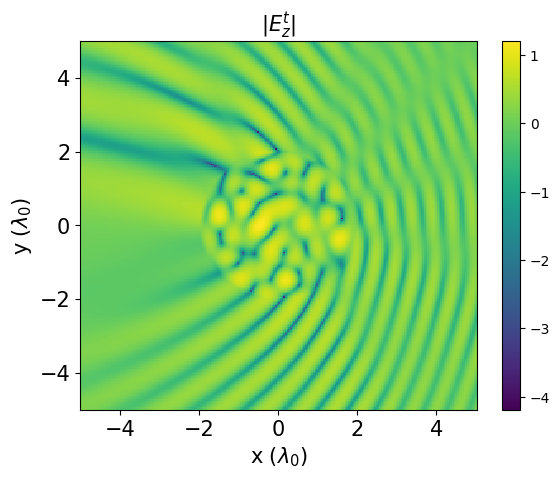

In [90]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_inv_scat), shading='auto')
plt.title(r'|$E^{s}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log(np.abs(e_total)), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()